In [1]:
from sklearn.model_selection import GroupKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_enrich = pd.read_csv('../data/enriched_nba_player_data.csv')
df_raw = pd.read_csv('../data/historic_nba_player_data.csv')
df_enrich

,Season,Player,MP,PTS,AST,TRB,STL,BLK,TS%,PER,WS,BPM,VORP,USG%,W/L%,VORP_W/L,Share
0,2003,Tracy McGrady,1.752518,3.906772,1.976588,0.989477,2.029217,0.547788,1.094251,3.679828,3.819312,3.533756,5.219498,3.400096,0.512,4.542465,0.359
1,2003,Kobe Bryant,1.989500,3.547491,2.208540,1.160492,3.127797,0.547788,0.822543,2.769521,3.455285,2.480413,4.230047,2.923437,0.610,4.473849,0.417
2,2003,Allen Iverson,2.102348,3.136883,1.976588,0.006143,4.226377,-0.554120,-0.147845,1.659390,1.726161,1.365108,2.436666,2.923437,0.585,2.467411,0.070
3,2003,Shaquille O'Neal,1.571961,3.119774,0.584878,2.956146,-0.387660,3.486209,1.831746,3.502207,2.939582,2.294529,2.869551,2.363881,0.610,3.048417,0.106
4,2003,Paul Pierce,1.729949,2.846035,1.338721,1.331507,2.248933,0.547788,0.473203,1.992429,1.999180,1.798838,2.807710,2.985610,0.537,2.564918,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9264,2025,John Konchar,-1.395727,-1.304718,-0.850703,-0.383064,-0.204874,-0.408694,0.377048,-0.469053,-0.463602,0.790282,-0.127939,-1.964855,0.585,-0.129821,0.000
9265,2025,Miles Norris,-1.448642,-1.320769,-1.343209,-0.513075,-0.204874,-0.408694,-3.342469,-1.300337,-1.038213,-0.378206,-0.515632,-1.163180,0.744,-0.497531,0.000
9266,2025,Dwight Powell,-1.673532,-1.352871,-0.795980,-0.903111,-1.249105,-0.168899,2.268063,-0.284323,-0.386988,0.238496,-0.283016,-2.037734,0.476,-0.318013,0.000
9267,2025,Jericho Sims,-1.422184,-1.401025,-1.014872,-0.209715,-1.510163,-0.168899,1.111574,-0.953968,-0.540217,-0.735245,-0.670709,-2.037734,0.500,-0.623244,0.000


- This model will be a hybrid model, first classifying if the player will get votes, then predicting how much vote share they get, with the final prediction being a product of the results
- The baseline is a prediction of zero for every player, since most players get zero vote share

In [3]:
train = df_enrich[df_enrich['Season'] < 2025].copy()
test = df_enrich[df_enrich['Season'] == 2025].copy()

In [4]:
train['has_votes'] = (train['Share'] > 0).astype(int)

In [5]:
X = train[['MP', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TS%', 'PER', 'WS', 'BPM', 'VORP', 'USG%', 'W/L%', 'VORP_W/L']]

y_vote = train['has_votes']
y_share = train['Share']

X_train, X_test, y_train_vote, y_test_vote, y_train_share, y_test_share = train_test_split(X, y_vote, y_share, test_size=0.2, 
                                                                                           random_state=69, stratify=y_vote)

In [50]:
pipe_class = Pipeline([
    ('Logistic', LogisticRegression(penalty='l1', C=1.0, solver='liblinear'))
])

In [51]:
pipe_class.fit(X_train, y_train_vote)

Pipeline(steps=[('Logistic',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

In [52]:
train_pred_vote = pipe_class.predict(X_train)
test_pred_vote = pipe_class.predict(X_test)
base = np.zeros(len(test_pred_vote))

mae_train = mean_absolute_error(y_train_vote, train_pred_vote)
mae_test = mean_absolute_error(y_test_vote, test_pred_vote)
baseline_vote = mean_absolute_error(y_test_vote, base)

print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Baseline MAE:", baseline_vote)

Train MAE: 0.013906626933446856
Test MAE: 0.014755959137343927
Baseline MAE: 0.03348467650397276


In [53]:
pipe_regr = Pipeline([
    ('Poly', PolynomialFeatures(degree=2)),
    ('Linear', LinearRegression())
])

In [54]:
pipe_regr.fit(X_train, y_train_share)

Pipeline(steps=[('Poly', PolynomialFeatures()), ('Linear', LinearRegression())])

In [55]:
train_pred_share = pipe_regr.predict(X_train)
test_pred_share = pipe_regr.predict(X_test)
#Set negative values to 0
test_pred_share = np.clip(test_pred_share, a_min=0, a_max=None)
base = np.zeros(len(test_pred_share))

mae_train = mean_absolute_error(y_train_share, train_pred_share)
mae_test = mean_absolute_error(y_test_share, test_pred_share)
baseline = mean_absolute_error(y_test_share, base)

print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Baseline MAE:", baseline)
print("r2_score:", r2_score(y_test_share, test_pred_share))

Train MAE: 0.010820173407837452
Test MAE: 0.006836928777605071
Baseline MAE: 0.005969353007945517
r2_score: 0.796902304164887


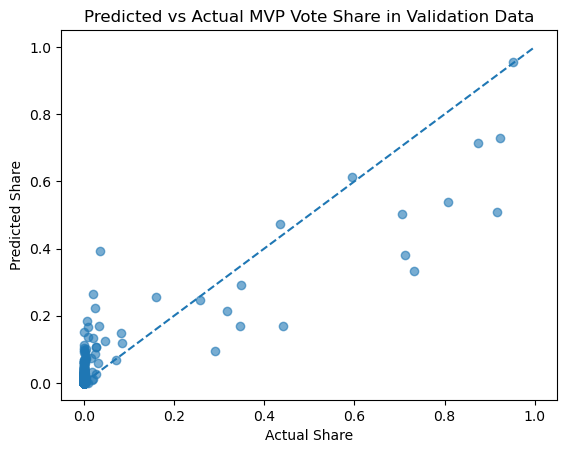

In [56]:
plt.scatter(y_test_share, test_pred_share, alpha=0.6)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Actual Share")
plt.ylabel("Predicted Share")
plt.title("Predicted vs Actual MVP Vote Share in Validation Data")
plt.show()

In [57]:
test_pred = test_pred_share * test_pred_vote
base = np.zeros(len(test_pred))

mae_test = mean_absolute_error(y_test_share, test_pred)
baseline = mean_absolute_error(y_test_share, base)

print("Test MAE:", mae_test)
print("Baseline MAE:", baseline)
print("r2_score:", r2_score(y_test_share, test_pred))

Test MAE: 0.003577055968559544
Baseline MAE: 0.005969353007945517
r2_score: 0.8143655285605037


In [58]:
train.loc[X_test.index, 'pred_share'] = test_pred_share
train.loc[X_test.index, 'pred_votes'] = test_pred_vote
train.loc[X_test.index, 'yhat'] = test_pred

In [59]:
df_val = train.dropna().sort_values(by=['yhat','pred_votes', 'Share', 'PTS'], ascending=False)
df_val[df_val['Season'] == 2007]

,Season,Player,MP,PTS,AST,TRB,STL,BLK,TS%,PER,...,BPM,VORP,USG%,W/L%,VORP_W/L,Share,has_votes,pred_share,pred_votes,yhat
1475,2007,Tracy McGrady,1.313379,2.441217,2.345457,0.493796,1.375970,0.081933,-0.301791,2.063118,...,2.371379,2.948421,3.268434,0.634,3.218556,0.085,1,0.118141,1.0,0.118141
1465,2007,Gilbert Arenas,1.768278,3.070463,2.077721,0.208044,2.825130,-0.486382,0.628493,2.239936,...,1.885496,2.812565,2.536176,0.500,2.308800,0.024,1,0.087077,1.0,0.087077
1487,2007,Baron Davis,1.256517,1.696056,3.202212,0.126401,3.308183,0.081933,-0.022706,1.576869,...,1.503731,1.589857,1.539491,0.512,1.325058,0.001,1,0.008792,0.0,0.000000
1498,2007,Tony Parker,0.938088,1.447669,1.809985,-0.363459,0.892917,-0.675821,0.758733,1.665278,...,1.330202,1.589857,1.722556,0.707,2.037517,0.001,1,0.044099,0.0,0.000000
1495,2007,Luol Deng,1.506711,1.480787,0.203568,1.228586,1.134443,0.271372,0.535465,1.068518,...,1.295496,2.065355,0.664849,0.598,2.117212,0.000,0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801,2007,Anthony Carter,-0.654058,-1.135555,1.809985,-1.057428,-1.763876,0.081933,-2.906588,-2.335226,...,-2.383330,-0.651774,-0.555582,0.549,-0.608288,0.000,0,0.021635,0.0,0.000000
1809,2007,C.J. Miles,-1.609345,-1.185232,-0.760282,-1.302358,-1.039296,-0.675821,-2.441446,-2.445737,...,-2.279212,-0.923487,-0.087750,0.622,-0.900693,0.000,0,0.000000,0.0,0.000000
1816,2007,Jake Tsakalidis,-1.529738,-1.251469,-1.081565,-0.485924,-1.280823,-0.296944,-1.120442,-1.208012,...,-1.585094,-0.787630,-1.165797,0.500,-0.716870,0.000,0,0.002739,0.0,0.000000
1818,2007,Jason Collins,-0.130924,-1.284587,-0.813829,-0.036886,-0.556243,0.081933,-2.292601,-2.401532,...,-1.758623,-1.806554,-2.406568,0.500,-1.573191,0.000,0,0.000000,0.0,0.000000


In [60]:
df_2025 = df_raw[df_raw['Season'] == 2025].copy()
X_2025 = df_2025[['MP', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TS%', 'PER', 'WS', 'BPM', 'VORP', 'USG%', 'W/L%']]
X_2025['VORP_W/L'] = X_2025['VORP'] * X_2025['W/L%']

scaler = StandardScaler()
scaler.fit(X_2025)
X_2025 = scaler.transform(X_2025)

pred_2025 = df_2025.copy()
pred_2025['pred_vote'] = pipe_class.predict(X_2025)
pred_2025['pred_share'] = np.clip(pipe_regr.predict(X_2025), a_min=0, a_max=None)
pred_2025['yhat'] = pred_2025['pred_vote'] * pred_2025['pred_share']
pred_2025[['Player', 'Share', 'pred_share', 'pred_vote', 'yhat']].sort_values(by=['yhat', 'Share', 'pred_share', 'pred_vote'], ascending=False).head(30)

C:\Users\alecw\AppData\Local\Temp\ipykernel_18680\2879212935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2025['VORP_W/L'] = X_2025['VORP'] * X_2025['W/L%']
D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


,Player,Share,pred_share,pred_vote,yhat
10774,Shai Gilgeous-Alexander,0.913,1.844761,1,1.844761
10776,Nikola Jokić,0.787,0.982051,1,0.982051
10775,Giannis Antetokounmpo,0.470,0.431452,1,0.431452
10779,Jayson Tatum,0.311,0.277344,1,0.277344
10792,LeBron James,0.016,0.165761,1,0.165761
10777,Luka Dončić,0.000,0.162519,1,0.162519
10835,Tyrese Haliburton,0.000,0.153294,1,0.153294
10778,Anthony Edwards,0.012,0.151043,1,0.151043
10791,Stephen Curry,0.002,0.145312,1,0.145312
10804,James Harden,0.001,0.137026,1,0.137026


In [61]:
base = np.zeros(len(pred_2025))

mae_test = mean_absolute_error(pred_2025['yhat'], pred_2025['Share'])
mse_test = mean_squared_error(pred_2025['yhat'], pred_2025['Share'])
baseline = mean_absolute_error(base, pred_2025['Share'])

print("Test MAE:", mae_test)
print("Test MSE:", mse_test)
print("Baseline MAE:", baseline)
print("R2 score:", r2_score(pred_2025['Share'], pred_2025['yhat']))

Test MAE: 0.0049924579694238
Test MSE: 0.0019437654564789515
Baseline MAE: 0.004569420035149385
R2 score: 0.3732650916654816


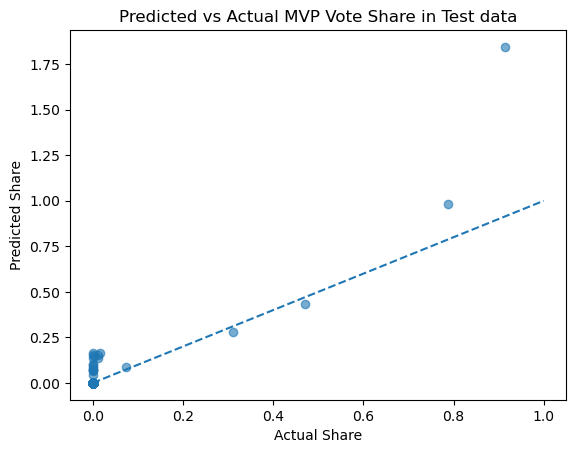

In [62]:
plt.scatter(pred_2025['Share'], pred_2025['yhat'], alpha=0.6)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Actual Share")
plt.ylabel("Predicted Share")
plt.title("Predicted vs Actual MVP Vote Share in Test data")
plt.show()

Notes:
- Linear model doesn't perform well on unseen test data, with an MAE of 0.0049 compared to a baseline of 0.0045 and an r2 score of 0.37
- However it accurately ranks the players with the most vote share
- Some values are above a 1 which is not seen in the training data
- The model seems to overfit the training data, the model overpredicts players with low minutes 
- This model should provide a good baseline to assess different models